# Oceanum Otis wrapper demo

Requirements:

* onotis
* oceanum

In [1]:
import os
import logging.config
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import oceantide
from oceantide import read_otis_netcdf, read_otis_binary
from oceantide.core.otis import read_otis_bin_h

from oncore.core import Grid
from oncore import LOGGING_CONFIG
from onotis import OtisAtlas, BathyFile, DEFAULT_CONS, SALFILE

In [2]:
logging.config.dictConfig(LOGGING_CONFIG)
logger = logging.getLogger(__name__)

---
## Preamble

### Define grid

The oncore Grid object defines the model grid:

In [3]:
grid = Grid(x0=165, x1=179.5, y0=-48.0, y1=-34.0, dx=0.5, dy=0.5)
print(f"Grid extension: ({grid.nx}, {grid.ny}), grid resolution: ({grid.dx}, {grid.dy})")

Grid extension: (30, 29), grid resolution: (0.5, 0.5)


### Define bathy

The otis wrapper requires **Bathy** objects with a`get` method which returns an xarray dataset in a specific convention expected by the wrapper. there are currently 4 different options:

* **BathyFile**: Fetch bathy from existing local file
* **BathyIntake**: Fetch bathy from intake catalog
* **BathyOntake**: Fetch bathy from Ontake library
* **BathyDatamesh**: Fetch bathy from Datamesh

**BathyOntake** is the only object that deals with different longitude conventions and date-line crossing and performs some inclusion checks in the source datasource before fetching, all others require the user to deal with these things separately.

In [4]:
bathy = BathyFile(
    filename="/source/onotis/tests/test_files/bathy/gebco_subset.zarr",
    engine="zarr",
    zname="elevation",
    invert=True,
)
bathy

BathyFile(filename='/source/onotis/tests/test_files/bathy/gebco_subset.zarr', engine='zarr', xname='lon', yname='lat', zname='elevation', invert=True, grid=None)

2022-11-23 23:26:14,274 [INFO] onotis.components.bathy:	Get bathy data.
2022-11-23 23:26:14,297 [INFO] onotis.components.bathy:	Validate bathy dataset


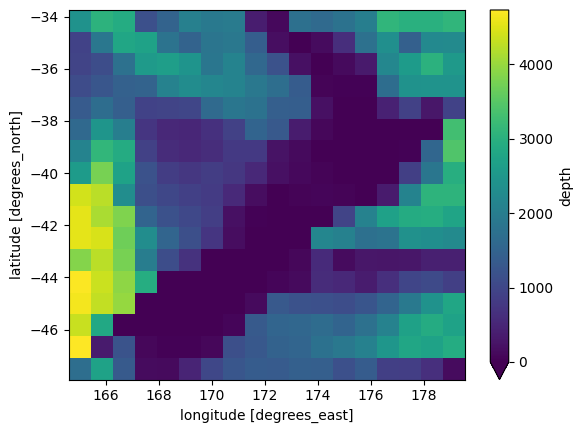

In [5]:
# View bathy

dset = bathy.get().sel(lon=slice(grid.x0, grid.x1), lat=slice(grid.y0, grid.y1))
p = dset.depth.plot(vmin=0, vmax=None)

### Define cons

Choose the first 8 for this test

In [6]:
DEFAULT_CONS

['m2',
 's2',
 'n2',
 'k2',
 'k1',
 'o1',
 'p1',
 'q1',
 'mm',
 'mf',
 'm4',
 'mn4',
 'ms4',
 '2n2']

In [7]:
cons = DEFAULT_CONS[:8]
cons

['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1']

---
## Model workflow

### Instantiate OtisAtlas wrapper

The OtisAtlas object uses gridded cons in [oceantide](https://github.com/oceanum/oceantide) zarr format such as the Atlas or any other appropriate zarr archive

In [8]:
oa = OtisAtlas(
    dataset_id="testrun",
    grid=grid,
    bathy=bathy,
    rootdir="/source/onotis/notebooks/rootdir",
    updir="/source/onotis/notebooks/updir",
    cons=cons,
    smooth_fac=None,
    hmin=2,
    bnd_namespace="tide",
    bnd_dataset_id="otis_tpxo9_atlas_v4_test",
    bnd_master_url="/source/onotis/tests/test_files/oceanum.yml",
    salfile=SALFILE, # This takes a bit to download from the bucket during preprocess, optimise it by storing it locally and specified path here,
    # salfile=None,
)

2022-11-23 23:26:36,515 [INFO] onotis.onotis:	
<class 'onotis.onotis.OtisAtlas'>
rootdir: /source/onotis/notebooks/rootdir/testrun
extents: <Grid x0=165 x1=179.5 y0=-48.0 y1=-34.0>
res: 0.5 by 0.5
cons: ['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1']
salfile: gs://oceanum-tide/otisoo/DB/sal_file
bathy: BathyFile(filename='/source/onotis/tests/test_files/bathy/gebco_subset.zarr', engine='zarr', xname='lon', yname='lat', zname='elevation', invert=True, grid=None)
bnd: tide.otis_tpxo9_atlas_v4_test



### Preprocess

The preprocess method sets up the model environment and creates the required input files. Most of the time spent here will be fetching data particularly the salfile so it helps downloading it from the bucket and storing locally if running the model multiple times.

In [9]:
oa.preprocess()

2022-11-23 23:26:50,433 [INFO] onotis.onotis:	================================================================================
2022-11-23 23:26:50,434 [INFO] onotis.onotis:	Preprocessing model data for testrun
2022-11-23 23:26:50,435 [INFO] onotis.onotis:	================================================================================
2022-11-23 23:26:50,436 [INFO] onotis.onotis:	Setting environment
2022-11-23 23:26:50,439 [INFO] onotis.onotis:	Setting max RAM in /source/onotis/notebooks/rootdir/testrun/exe/run_param from system memory: 16487 Mb
2022-11-23 23:26:50,777 [INFO] onotis.onotis:	Fetching SAL file gs://oceanum-tide/otisoo/DB/sal_file --> /source/onotis/notebooks/rootdir/testrun/input/sal_file
2022-11-23 23:26:51,059 [INFO] oncore.dataio:	        downloading gs://oceanum-tide/otisoo/DB/sal_file to /source/onotis/notebooks/rootdir/testrun/input/sal_file
2022-11-23 23:27:59,416 [INFO] onotis.onotis:	Creating bathy file /source/onotis/notebooks/rootdir/testrun/input/bathy.dat
20

If run successfully, preprocess with set up the environment with required input files in `{rootdir}/{dataset_id}` location:

In [12]:
print(oa.rootdir)
!ls ./rootdir/testrun/*

/source/onotis/notebooks/rootdir/testrun
./rootdir/testrun/bathy:

./rootdir/testrun/dat:

./rootdir/testrun/exe:
bhat_samp    Lat_lon   mkFrv	ob_eval   rpx_to_rp  stats_rlz
data_cooker  Makedat   mk_g_ll	reduce_B  run_param  Sumreps
Diffuse      makefile  mk_grid	repX	  Scfac      Varest
Fwd_fac      mkB       NFF	rlcX	  Sml_df

./rootdir/testrun/input:
bathy.dat  h_boundary  model_boundary  sal_file

./rootdir/testrun/otis_binary:

./rootdir/testrun/otis_netcdf:

./rootdir/testrun/out:

./rootdir/testrun/prm:
cf_difvar  Constituents

./rootdir/testrun/repx1:


### Check generated binary boundary file

The [read_otis_bin_h](https://github.com/oceanum/oceantide/blob/master/oceantide/core/otis.py#L283) function reads elevation binary file and returns an xarray dataset in Otis netcdf convention


In [13]:
dset_bnd = read_otis_bin_h(f"{Path(oa.rootdir) / 'input/h_boundary'}")
dset_bnd

<xarray.Dataset>
Dimensions:  (nc: 14, nx: 3, ny: 3)
Dimensions without coordinates: nc, nx, ny
Data variables:
    con      (nc) |S4 dask.array<chunksize=(14,), meta=np.ndarray>
    lon_z    (nx, ny) float64 dask.array<chunksize=(3, 3), meta=np.ndarray>
    lat_z    (nx, ny) float64 dask.array<chunksize=(3, 3), meta=np.ndarray>
    hRe      (nc, nx, ny) float64 dask.array<chunksize=(14, 3, 3), meta=np.ndarray>
    hIm      (nc, nx, ny) float64 dask.array<chunksize=(14, 3, 3), meta=np.ndarray>
Attributes:
    type:     OTIS tidal elevation file
    title:    Oceantide tidal elevation from binary file

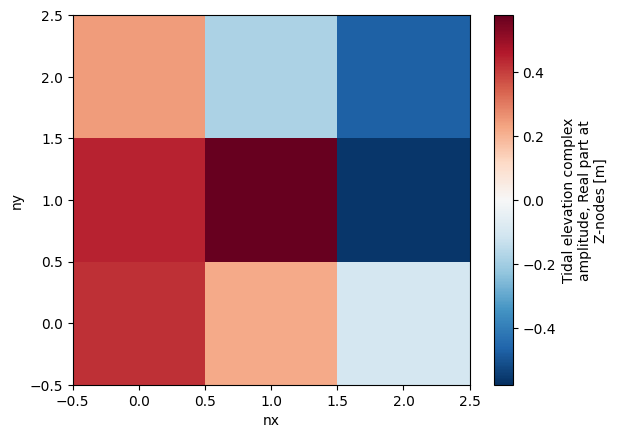

In [14]:
# Plot the real component of M2 from the boundary

cons = [c.decode().strip() for c in dset_bnd.con.values]
im2 = cons.index("m2")
h = dset_bnd.hRe.isel(nc=im2).transpose("ny", "nx").plot()

### Run

The run method executes the following model files:

* mk_grid
* ob_eval
* Fwd_fac

In [15]:
%%time

oa.run()

2022-11-23 23:30:00,359 [INFO] onotis.onotis:	================================================================================
2022-11-23 23:30:00,361 [INFO] onotis.onotis:	Running OSU model for testrun
2022-11-23 23:30:00,362 [INFO] onotis.onotis:	================================================================================
2022-11-23 23:30:00,362 [INFO] onotis.onotis:	Run mk_grid
2022-11-23 23:30:00,368 [INFO] onotis.execute:	You are running mkgrid for creating standard
2022-11-23 23:30:00,369 [INFO] onotis.execute:	OTIS grid using one of bathymetry DB or your
2022-11-23 23:30:00,369 [INFO] onotis.execute:	local bathymetry:
2022-11-23 23:30:00,370 [INFO] onotis.execute:	mk_grid usage:
2022-11-23 23:30:00,371 [INFO] onotis.execute:	mk_grid [-g<output_grid_name>]
2022-11-23 23:30:00,371 [INFO] onotis.execute:	[-G<GEBCO_bathy_name_with_path>]
2022-11-23 23:30:00,372 [INFO] onotis.execute:	[-S<Smith&Sandwell_bathy_name_with_path>]
2022-11-23 23:30:00,373 [INFO] onotis.execute:	[-l<loc

The main outputs are binary files with the depth grid and cons for elevation and transport created in `{rootdir}`:

In [16]:
!ls rootdir/testrun/prm/grid
!ls rootdir/testrun/out/h0.df.out
!ls rootdir/testrun/out/h0.df.out

rootdir/testrun/prm/grid
rootdir/testrun/out/h0.df.out
rootdir/testrun/out/h0.df.out


### Postprocess

The postprocess method executes the following tasks:

* Writes the binary output into Otis netcdf format
* Writes the binary output into Oceantide zarr format
* Uploads model data to the specified location which can be a cloud bucket

In [17]:
oa.postprocess()

2022-11-23 23:30:54,138 [INFO] onotis.onotis:	================================================================================
2022-11-23 23:30:54,142 [INFO] onotis.onotis:	Postprocessing model data for testrun
2022-11-23 23:30:54,145 [INFO] onotis.onotis:	================================================================================
2022-11-23 23:30:54,147 [INFO] onotis.onotis:	Writting zarr cons dataset: /source/onotis/notebooks/rootdir/testrun/testrun.zarr
2022-11-23 23:30:54,636 [INFO] onotis.onotis:	Packing Otis binary and netcdf output


/home/rguedes/.virtualenvs/onotis/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/rguedes/.virtualenvs/onotis/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/rguedes/.virtualenvs/onotis/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


2022-11-23 23:30:55,118 [INFO] onotis.onotis:	Uploading model to: /source/onotis/notebooks/updir/testrun/
2022-11-23 23:30:55,119 [INFO] oncore.dataio:	        uploading file /source/onotis/notebooks/rootdir/testrun/exe/run_param to /source/onotis/notebooks/updir/testrun/run_param
2022-11-23 23:30:55,120 [INFO] oncore.dataio:	        uploading file /source/onotis/notebooks/rootdir/testrun/input/h_boundary to /source/onotis/notebooks/updir/testrun/h_boundary
2022-11-23 23:30:55,121 [INFO] oncore.dataio:	        uploading file /source/onotis/notebooks/rootdir/testrun/otis_binary to /source/onotis/notebooks/updir/testrun/
2022-11-23 23:30:55,123 [INFO] oncore.dataio:	        uploading file /source/onotis/notebooks/rootdir/testrun/otis_netcdf to /source/onotis/notebooks/updir/testrun/
2022-11-23 23:30:55,125 [INFO] oncore.dataio:	        uploading file /source/onotis/notebooks/rootdir/testrun/testrun.zarr to /source/onotis/notebooks/updir/testrun/


---
## Check results

### Check model output from native (binary) and postprocessed formats (netcdf and zarr)

In [18]:
# Read native Otis binary format into an oceantide dataset
dscon_binary = read_otis_binary("/source/onotis/notebooks/updir/testrun/otis_binary/Model_testrun")

# Read converted Otis netcdf format into an oceantide dataset
dscon_netcdf = read_otis_netcdf("/source/onotis/notebooks/updir/testrun/otis_netcdf/Model_testrun")

# Read converted oceantide zarr file into an oceantide dataset
dscon_zarr = xr.open_dataset("/source/onotis/notebooks/updir/testrun/testrun.zarr", engine="zarr", chunks={})

dscon_zarr

<xarray.Dataset>
Dimensions:  (con: 8, lat: 29, lon: 30)
Coordinates:
  * con      (con) <U4 'M2' 'S2' 'N2' 'K2' 'K1' 'O1' 'P1' 'Q1'
  * lat      (lat) float64 -48.0 -47.5 -47.0 -46.5 ... -35.5 -35.0 -34.5 -34.0
  * lon      (lon) float64 165.0 165.5 166.0 166.5 ... 178.0 178.5 179.0 179.5
Data variables:
    dep      (lat, lon) float64 dask.array<chunksize=(29, 30), meta=np.ndarray>
    h        (con, lat, lon) complex128 dask.array<chunksize=(8, 29, 30), meta=np.ndarray>
    u        (con, lat, lon) complex128 dask.array<chunksize=(8, 29, 30), meta=np.ndarray>
    v        (con, lat, lon) complex128 dask.array<chunksize=(8, 29, 30), meta=np.ndarray>
Attributes:
    description:  Oceantide tidal constituents

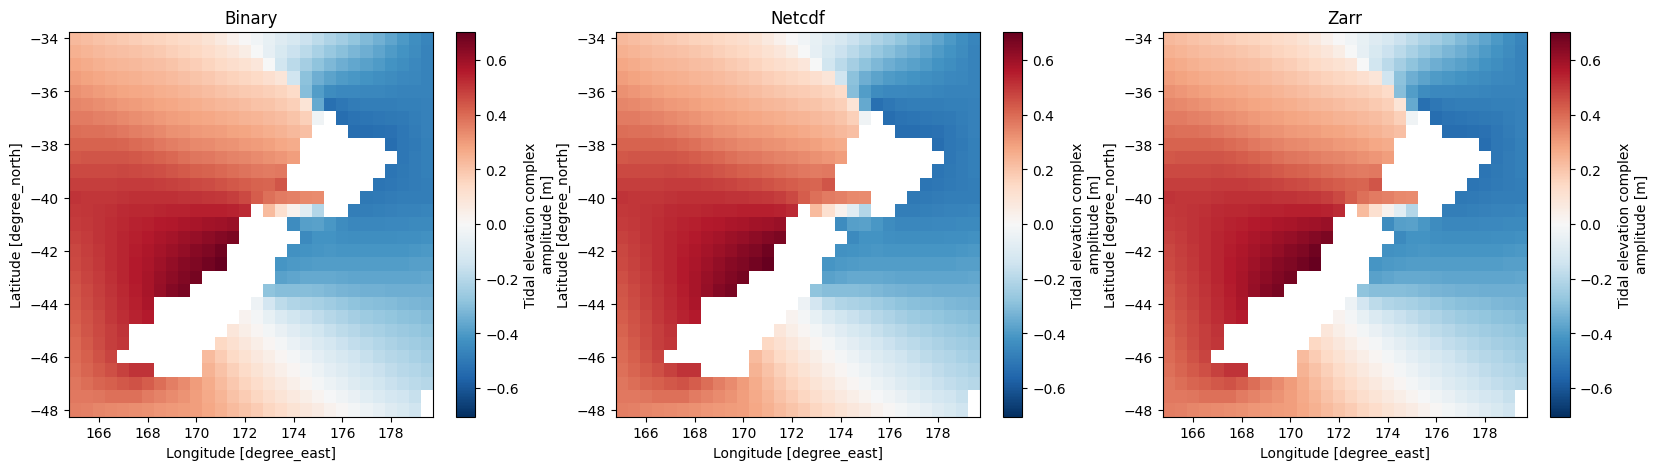

In [19]:
# Plotting real part of M2 for the 3 formats

fig = plt.figure(figsize=(20, 5))

# Binary
ax = fig.add_subplot(131)
dscon_binary.h.real.isel(con=0).plot()
plt.title("Binary")

# Netcdf
ax = fig.add_subplot(132)
dscon_netcdf.h.real.isel(con=0).plot()
plt.title("Netcdf")

# Zarr
ax = fig.add_subplot(133)
dscon_zarr.h.real.isel(con=0).plot()
plt.title("Zarr");

### Use oceantide to calculate elevation and current timeseries from the full grid

In [20]:
%%time

times = pd.date_range(start="20220101T00", end="20220101T23", freq="1H")

dseta = dscon_zarr.tide.predict(times=times).load()
dseta

CPU times: user 253 ms, sys: 19.7 ms, total: 273 ms
Wall time: 262 ms


<xarray.Dataset>
Dimensions:  (lat: 29, lon: 30, time: 24)
Coordinates:
  * lat      (lat) float64 -48.0 -47.5 -47.0 -46.5 ... -35.5 -35.0 -34.5 -34.0
  * lon      (lon) float64 165.0 165.5 166.0 166.5 ... 178.0 178.5 179.0 179.5
  * time     (time) datetime64[ns] 2022-01-01 ... 2022-01-01T23:00:00
Data variables:
    dep      (lat, lon) float64 2.199e+03 2.605e+03 ... 2.941e+03 3.029e+03
    h        (time, lat, lon) float64 0.3335 0.3383 0.343 ... -0.3708 -0.4192
    u        (time, lat, lon) float64 0.1326 0.1037 0.06865 ... 0.05937 0.03867
    v        (time, lat, lon) float64 -0.07571 -0.09139 ... -0.06176 -0.07428
Attributes:
    description:  Tide elevation and currents time series

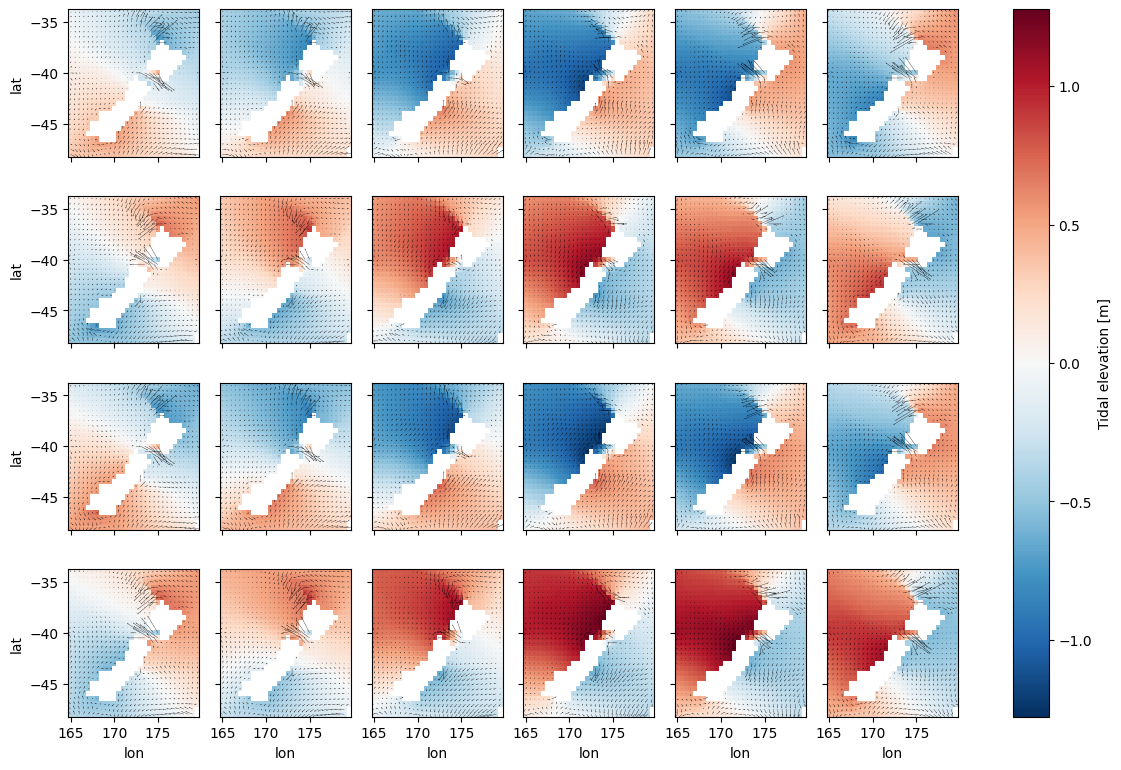

In [21]:
# Plot gridded output

p = dseta.h.plot(col="time", col_wrap=6, figsize=(12, 8));
for ind, ax in enumerate(p.axs.flat):
    ds = dseta.isel(time=ind)
    ax.quiver(ds.lon, ds.lat, ds.u, ds.v)
    ax.set_title("")

### Use oceantide to calculate 10-year hourly elevation and current timeseries from single point

In [22]:
%%time

times = pd.date_range(start="20220101T00", end="20320101T00", freq="1H")

df = dscon_zarr.sel(lat=-41, lon=174.6, method="nearest").load().tide.predict(times=times, time_chunk=None).to_dataframe()
df

CPU times: user 347 ms, sys: 40.3 ms, total: 387 ms
Wall time: 382 ms


,lat,lon,dep,h,u,v
time,,,,,,
2022-01-01 00:00:00,-41.0,174.5,120.0,-0.188227,0.176957,-0.236862
2022-01-01 01:00:00,-41.0,174.5,120.0,0.002206,0.132067,-0.108629
2022-01-01 02:00:00,-41.0,174.5,120.0,0.192332,0.055053,0.046819
2022-01-01 03:00:00,-41.0,174.5,120.0,0.332263,-0.034076,0.190355
2022-01-01 04:00:00,-41.0,174.5,120.0,0.384607,-0.112294,0.285681
...,...,...,...,...,...,...
2031-12-31 20:00:00,-41.0,174.5,120.0,0.394458,-0.145951,0.249144
2031-12-31 21:00:00,-41.0,174.5,120.0,0.396015,-0.162228,0.234071
2031-12-31 22:00:00,-41.0,174.5,120.0,0.310877,-0.140973,0.161350


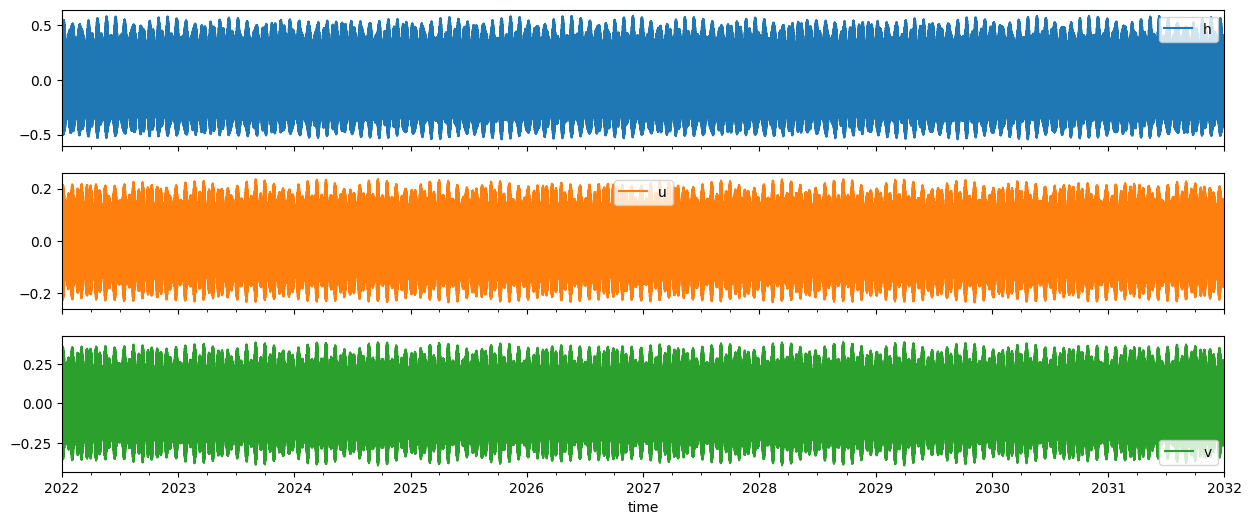

In [23]:
df[["h", "u", "v"]].plot(subplots=True, figsize=(15, 6));

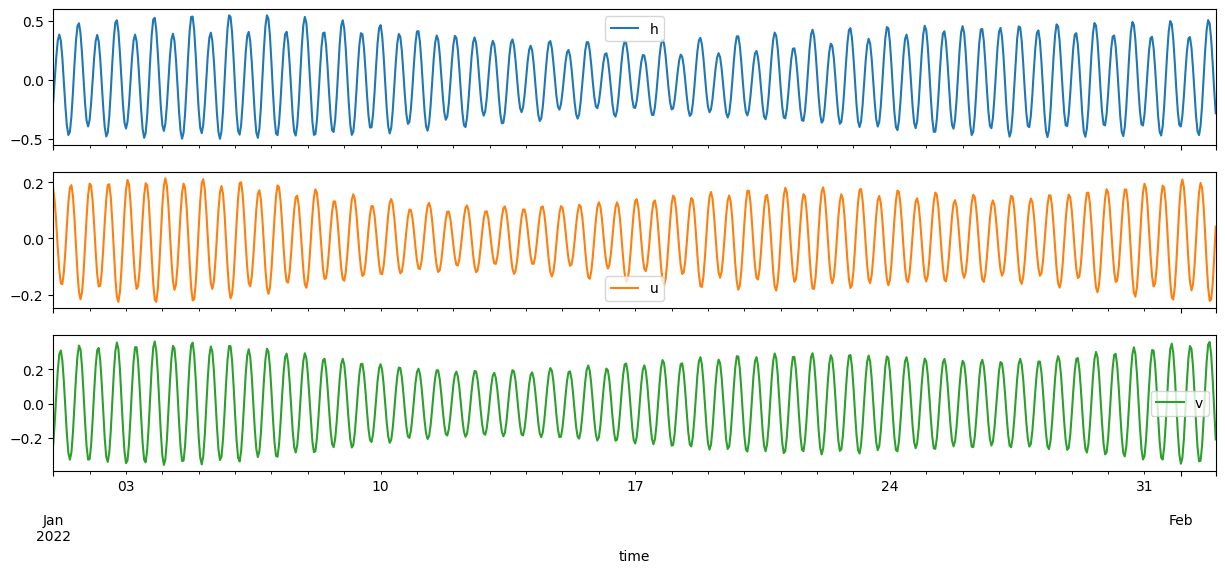

In [24]:
df[["h", "u", "v"]].loc["20220101": "20220201"].plot(subplots=True, figsize=(15, 6));